# Testing Different Classification Models with Caret

In [21]:
library(plyr)
library(dplyr)
library(ggplot2)
library(caret)
# library(RANN)
library(doMC)
registerDoMC(cores = 2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [22]:
train <- read.csv('datasets/train_edited.csv', stringsAsFactors = TRUE)
str(train)
sum(is.na(train))

'data.frame':	889 obs. of  11 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 889 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 558 519 628 416 580 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 680 levels "110152","110413",..: 523 596 669 49 472 275 85 395 344 132 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


[1] 0

In [23]:
#get rid of useless features
train <- train %>% select(-PassengerId, -Name, -Ticket)
train_survived <- train$Survived

In [24]:
preProcValues <- preProcess(train, method = c("center", "scale"))
train_processed <- predict(preProcValues, train)
train_processed$Survived <- train_survived
head(train_processed)

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.8247444,male,-0.590162723,0.4311076,-0.474059,-0.4999583,S
1,-1.5713267,female,0.643608719,0.4311076,-0.474059,0.7885028,C
1,0.8247444,female,-0.281719862,-0.4749317,-0.474059,-0.4863762,S
1,-1.5713267,female,0.412276574,0.4311076,-0.474059,0.4226232,S
0,0.8247444,male,0.412276574,-0.4749317,-0.474059,-0.4838609,S
0,0.8247444,male,0.003521745,-0.4749317,-0.474059,-0.4756452,Q


In [25]:
dmy <- dummyVars("~ .", data = train_processed, fullRank = TRUE)
train_transformed <- data.frame(predict(dmy, newdata = train_processed))
str(train_transformed)

'data.frame':	889 obs. of  9 variables:
 $ Survived  : num  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass    : num  0.825 -1.571 0.825 -1.571 0.825 ...
 $ Sex.male  : num  1 0 0 0 1 1 1 1 0 0 ...
 $ Age       : num  -0.59 0.644 -0.282 0.412 0.412 ...
 $ SibSp     : num  0.431 0.431 -0.475 0.431 -0.475 ...
 $ Parch     : num  -0.474 -0.474 -0.474 -0.474 -0.474 ...
 $ Fare      : num  -0.5 0.789 -0.486 0.423 -0.484 ...
 $ Embarked.Q: num  0 0 0 0 0 1 0 0 0 0 ...
 $ Embarked.S: num  1 0 1 1 1 0 1 1 1 0 ...


In [26]:
#not sure if we need to convert survived into a factor - might as well but experiment
train_transformed$Survived <- as.factor(train_transformed$Survived)

In [27]:
index <- createDataPartition(train_transformed$Survived, p = 0.75, list = FALSE)
trainSet <- train_transformed[index, ]
testSet <- train_transformed[-index, ]

str(trainSet)

'data.frame':	667 obs. of  9 variables:
 $ Survived  : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 1 2 1 1 ...
 $ Pclass    : num  0.825 -1.571 -1.571 0.825 0.825 ...
 $ Sex.male  : num  1 0 0 1 1 1 1 0 1 1 ...
 $ Age       : num  -0.59016 0.64361 0.41228 0.41228 0.00352 ...
 $ SibSp     : num  0.431 0.431 0.431 -0.475 -0.475 ...
 $ Parch     : num  -0.474 -0.474 -0.474 -0.474 -0.474 ...
 $ Fare      : num  -0.5 0.789 0.423 -0.484 -0.476 ...
 $ Embarked.Q: num  0 0 0 0 1 0 0 0 0 0 ...
 $ Embarked.S: num  1 0 1 1 0 1 1 1 1 1 ...


Possibly look into feature selection later on

In [28]:
predictors<-c("Pclass", "Sex.male", "Age", "SibSp", "Parch", "Fare", "Embarked.Q", "Embarked.S")
outcomeName <- "Survived"

In [29]:
fitControl <- trainControl(method = 'repeatedcv', number = 5, repeats = 5)
model_rf <- train(trainSet[, predictors], trainSet[, outcomeName], method = 'rf', trControl = fitControl)
model_glm <- train(trainSet[, predictors], trainSet[, outcomeName], method = 'glm', family = binomial(link = 'logit'), trControl = fitControl)
model_gbm <- train(trainSet[, predictors], trainSet[, outcomeName], method = 'gbm', trControl = fitControl)
model_nnet <- train(trainSet[, predictors], trainSet[, outcomeName], method = 'nnet', trControl = fitControl)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2573             nan     0.1000    0.0371
     2        1.1971             nan     0.1000    0.0294
     3        1.1468             nan     0.1000    0.0233
     4        1.1045             nan     0.1000    0.0203
     5        1.0706             nan     0.1000    0.0164
     6        1.0439             nan     0.1000    0.0101
     7        1.0151             nan     0.1000    0.0128
     8        0.9930             nan     0.1000    0.0094
     9        0.9770             nan     0.1000    0.0061
    10        0.9584             nan     0.1000    0.0061
    20        0.8508             nan     0.1000    0.0005
    40        0.7648             nan     0.1000   -0.0019
    60        0.7221             nan     0.1000   -0.0009
    80        0.6880             nan     0.1000   -0.0016
   100        0.6599             nan     0.1000   -0.0004
   120        0.6414             nan     0.1000    0.0006
   140        

## Random Forest

In [30]:
varImp(object = model_rf)

rf variable importance

           Overall
Sex.male   100.000
Fare        68.854
Age         51.774
Pclass      38.613
SibSp       14.312
Parch       12.136
Embarked.S   4.831
Embarked.Q   0.000

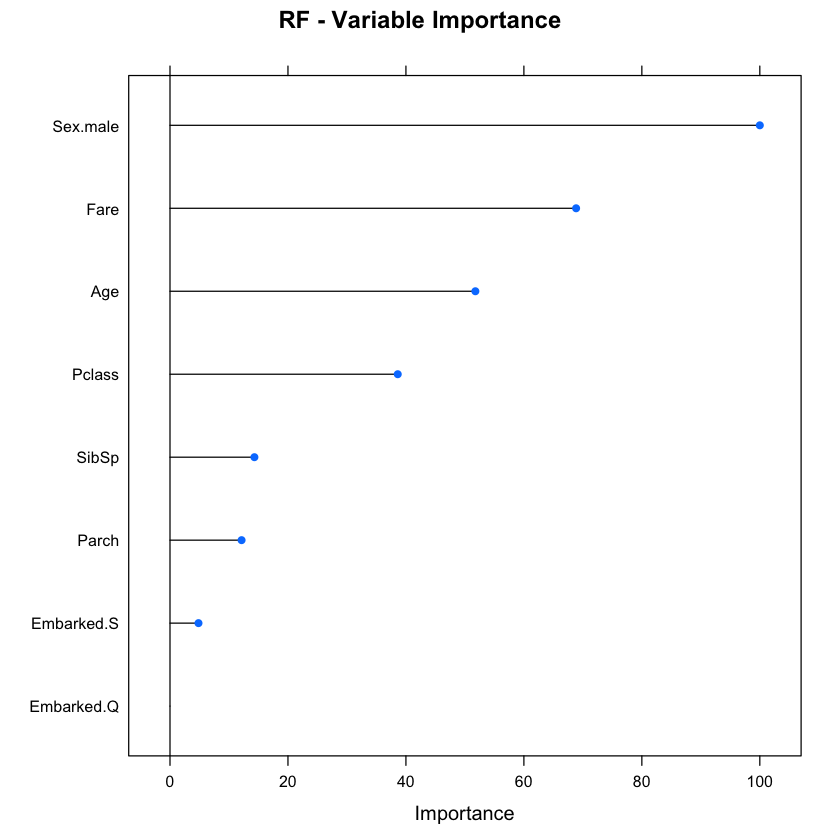

In [31]:
plot(varImp(object = model_rf), main="RF - Variable Importance")

In [32]:
predictions_rf <- predict.train(object = model_rf, testSet[, predictors], type = 'raw')
table(predictions_rf)

predictions_rf
  0   1 
155  67 

In [33]:
confusionMatrix(predictions_rf, testSet[, outcomeName])

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 128  27
         1   9  58
                                          
               Accuracy : 0.8378          
                 95% CI : (0.7826, 0.8838)
    No Information Rate : 0.6171          
    P-Value [Acc > NIR] : 5.643e-13       
                                          
                  Kappa : 0.6425          
 Mcnemar's Test P-Value : 0.004607        
                                          
            Sensitivity : 0.9343          
            Specificity : 0.6824          
         Pos Pred Value : 0.8258          
         Neg Pred Value : 0.8657          
             Prevalence : 0.6171          
         Detection Rate : 0.5766          
   Detection Prevalence : 0.6982          
      Balanced Accuracy : 0.8083          
                                          
       'Positive' Class : 0               
                                          

## General Linear Model - Logistic Regression

In [34]:
varImp(object = model_glm)

glm variable importance

            Overall
Sex.male   100.0000
Pclass      60.7254
Age         39.3666
SibSp       17.6167
Fare         6.6408
Embarked.S   5.3621
Embarked.Q   0.3959
Parch        0.0000

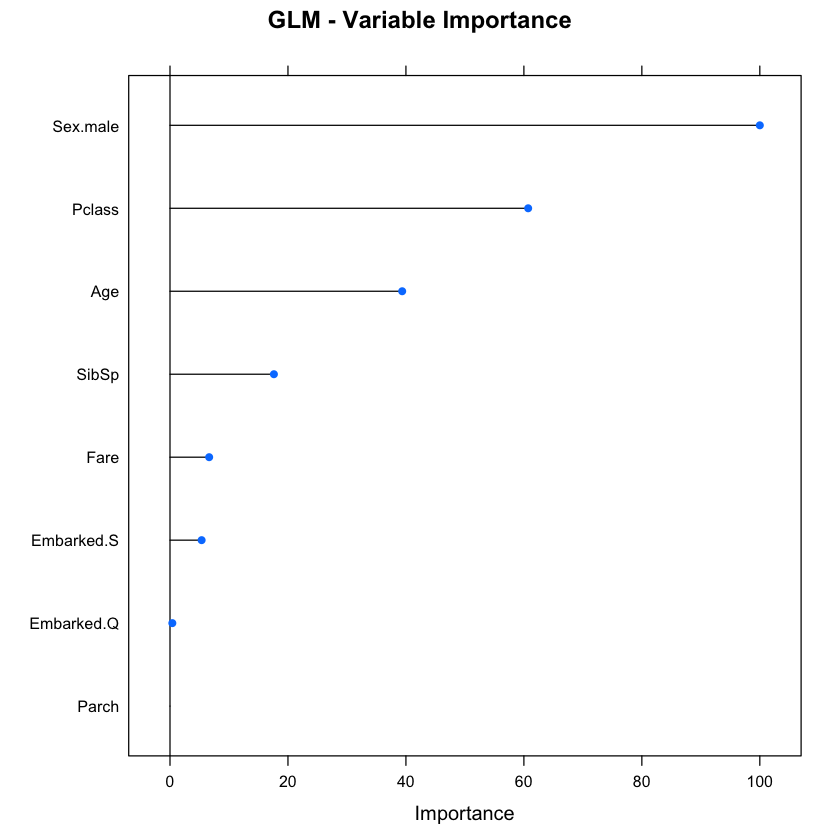

In [35]:
plot(varImp(object = model_glm), main="GLM - Variable Importance")

In [36]:
predictions_glm <- predict.train(object = model_glm, testSet[, predictors], type = 'raw')
table(predictions_glm)

predictions_glm
  0   1 
130  92 

In [37]:
confusionMatrix(predictions_glm, testSet[, outcomeName])

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 110  20
         1  27  65
                                          
               Accuracy : 0.7883          
                 95% CI : (0.7286, 0.8401)
    No Information Rate : 0.6171          
    P-Value [Acc > NIR] : 3.488e-08       
                                          
                  Kappa : 0.5589          
 Mcnemar's Test P-Value : 0.3815          
                                          
            Sensitivity : 0.8029          
            Specificity : 0.7647          
         Pos Pred Value : 0.8462          
         Neg Pred Value : 0.7065          
             Prevalence : 0.6171          
         Detection Rate : 0.4955          
   Detection Prevalence : 0.5856          
      Balanced Accuracy : 0.7838          
                                          
       'Positive' Class : 0               
                                          

## GBM - Generalized Boosted Regression Models

In [38]:
varImp(object = model_gbm)

gbm variable importance

           Overall
Sex.male   100.000
Fare        68.722
Age         65.971
Pclass      43.552
SibSp       12.267
Parch        7.958
Embarked.S   7.931
Embarked.Q   0.000

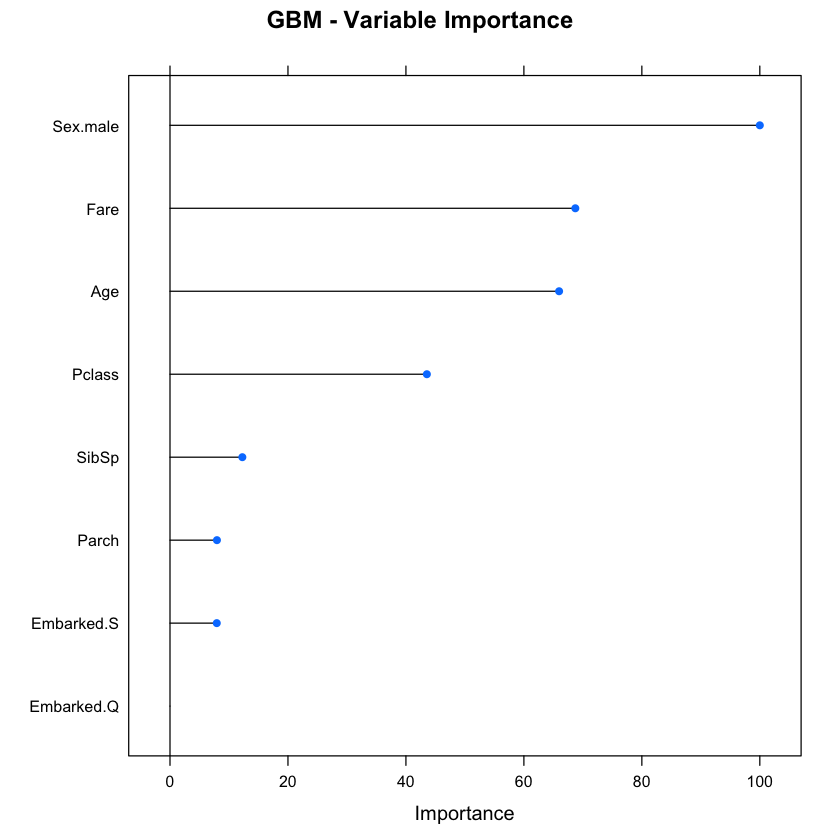

In [39]:
plot(varImp(object = model_gbm), main="GBM - Variable Importance")

In [40]:
predictions_gbm <- predict.train(object = model_gbm, testSet[, predictors], type = 'raw')
table(predictions_gbm)

predictions_gbm
  0   1 
145  77 

In [41]:
confusionMatrix(predictions_gbm, testSet[, outcomeName])

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 123  22
         1  14  63
                                          
               Accuracy : 0.8378          
                 95% CI : (0.7826, 0.8838)
    No Information Rate : 0.6171          
    P-Value [Acc > NIR] : 5.643e-13       
                                          
                  Kappa : 0.6506          
 Mcnemar's Test P-Value : 0.2433          
                                          
            Sensitivity : 0.8978          
            Specificity : 0.7412          
         Pos Pred Value : 0.8483          
         Neg Pred Value : 0.8182          
             Prevalence : 0.6171          
         Detection Rate : 0.5541          
   Detection Prevalence : 0.6532          
      Balanced Accuracy : 0.8195          
                                          
       'Positive' Class : 0               
                                          

## Neural Net

In [42]:
varImp(object = model_nnet)

nnet variable importance

           Overall
Sex.male   100.000
Parch       64.227
SibSp       50.392
Age         44.541
Fare        34.070
Embarked.Q  26.918
Pclass       6.221
Embarked.S   0.000

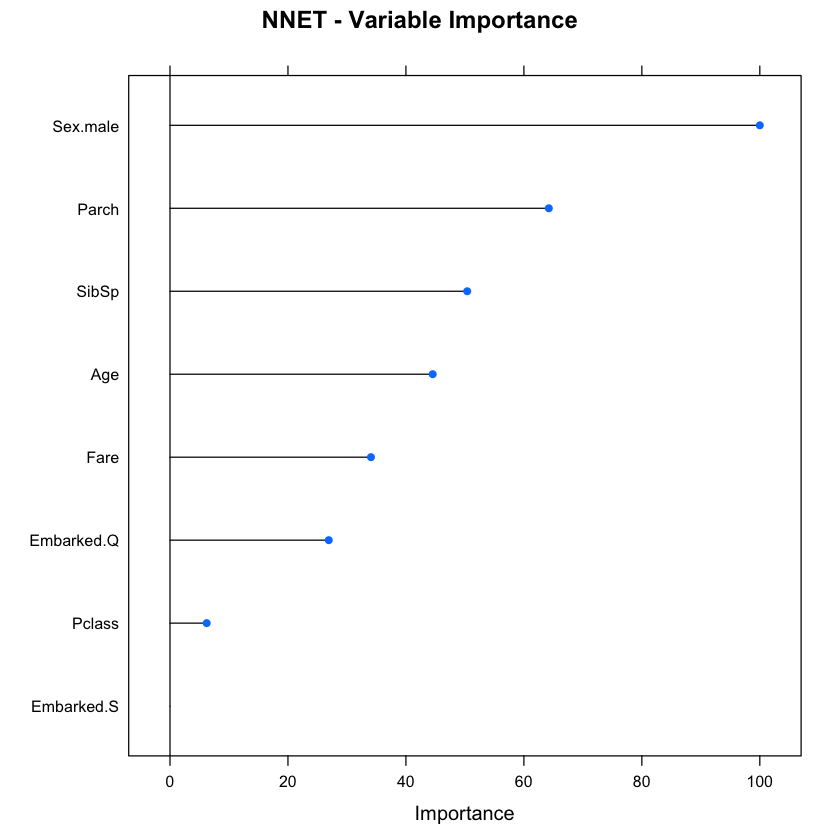

In [43]:
plot(varImp(object = model_nnet), main="NNET - Variable Importance")

In [44]:
predictions_nnet <- predict.train(object = model_nnet, testSet[, predictors], type = 'raw')
table(predictions_nnet)

predictions_nnet
  0   1 
150  72 

In [46]:
confusionMatrix(predictions_nnet, testSet[, outcomeName])

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 122  28
         1  15  57
                                          
               Accuracy : 0.8063          
                 95% CI : (0.7481, 0.8561)
    No Information Rate : 0.6171          
    P-Value [Acc > NIR] : 9.436e-10       
                                          
                  Kappa : 0.5779          
 Mcnemar's Test P-Value : 0.06725         
                                          
            Sensitivity : 0.8905          
            Specificity : 0.6706          
         Pos Pred Value : 0.8133          
         Neg Pred Value : 0.7917          
             Prevalence : 0.6171          
         Detection Rate : 0.5495          
   Detection Prevalence : 0.6757          
      Balanced Accuracy : 0.7805          
                                          
       'Positive' Class : 0               
                                          